In [1]:
import os
import sys
import gc

import time
import json
import random
import math
import numpy as np

import torch
from torch.optim.adamw import AdamW
from torch.nn.utils import clip_grad_norm_
import torch.distributed as dist
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import save_image


from wolf.data import load_datasets, get_batch, preprocess, postprocess
from wolf import WolfModel
from wolf.utils import total_grad_norm
from wolf.optim import ExponentialScheduler

from experiments.options import parse_args

from matplotlib import pyplot as plt

from tqdm import tqdm_notebook

import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
def is_master(rank):
    return rank <= 0

def is_distributed(rank):
    return rank >= 0

def logging(info, logfile=None):
    print(info)
    if logfile is not None:
        print(info, file=logfile)
        logfile.flush()

In [3]:
def init_dataloader(args, train_data, val_data):
    if is_distributed(args.rank):
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_data, rank=args.rank,
                                                                        num_replicas=args.world_size,
                                                                        shuffle=True)
    else:
        train_sampler = None
    train_loader = DataLoader(train_data, batch_size=args.batch_size,
                              shuffle=(train_sampler is None), sampler=train_sampler,
                              num_workers=args.workers, pin_memory=True, drop_last=True)
    if is_master(args.rank):
        eval_batch = args.eval_batch_size
        val_loader = DataLoader(val_data, batch_size=eval_batch, shuffle=False,
                                num_workers=args.workers, pin_memory=True)
    else:
        val_loader = None

    return train_loader, train_sampler, val_loader

In [4]:
def setup(args):
    def check_dataset():
        if dataset == 'cifar10':
            assert image_size == 32, 'CIFAR-10 expected image size 32 but got {}'.format(image_size)
        elif dataset.startswith('lsun'):
            assert image_size in [128, 256]
        elif dataset == 'celeba':
            assert image_size in [256, 512]
        elif dataset == 'imagenet':
            assert image_size in [64, 128, 256]

    dataset = args.dataset
    if args.category is not None:
        dataset = dataset + '_' + args.category
    image_size = args.image_size
    check_dataset()

    nc = 3
    args.nx = image_size ** 2 * nc
    n_bits = args.n_bits
    args.n_bins = 2. ** n_bits
    args.test_k = 1

    model_path = args.model_path
    args.checkpoint_name = os.path.join(model_path, 'checkpoint')

    result_path = os.path.join(model_path, 'images')
    args.result_path = result_path
    data_path = args.data_path

    if is_master(args.rank):
        if not os.path.exists(model_path):
            os.makedirs(model_path)
        if not os.path.exists(result_path):
            os.makedirs(result_path)
        if args.recover < 0:
            args.log = open(os.path.join(model_path, 'log.txt'), 'w')
        else:
            args.log = open(os.path.join(model_path, 'log.txt'), 'a')
    else:
        args.log = None

    args.cuda = torch.cuda.is_available()
    random_seed = args.seed + args.rank if args.rank >= 0 else args.seed
    if args.recover >= 0:
        random_seed += random.randint(0, 1024)
    logging("Rank {}: random seed={}".format(args.rank, random_seed), logfile=args.log)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    device = torch.device('cuda', args.local_rank) if args.cuda else torch.device('cpu')
    if args.cuda:
        torch.cuda.set_device(device)
        torch.cuda.manual_seed(random_seed)

    torch.backends.cudnn.benchmark = True

    args.world_size = int(os.environ["WORLD_SIZE"]) if is_distributed(args.rank) else 1
    logging("Rank {}: ".format(args.rank) + str(args), args.log)

    train_data, val_data = load_datasets(dataset, image_size, data_path=data_path)
    train_index = np.arange(len(train_data))
    np.random.shuffle(train_index)
    val_index = np.arange(len(val_data))

    if is_master(args.rank):
        logging('Data size: training: {}, val: {}'.format(len(train_index), len(val_index)))

    if args.recover >= 0:
        params = json.load(open(os.path.join(model_path, 'config.json'), 'r'))
    else:
        params = json.load(open(args.config, 'r'))
        json.dump(params, open(os.path.join(model_path, 'config.json'), 'w'), indent=2)

    wolf = WolfModel.from_params(params)
    wolf.to_device(device)
    args.device = device
    
    if args.recover >= 0:
        wolf = WolfModel.load(args.model_path, args.device, 0)
#         checkpoint_name = args.checkpoint_name + '{}.tar'.format(args.recover)
#         print(f"Rank = {args.rank}, loading from checkpoint {checkpoint_name}")

#         checkpoint = torch.load(checkpoint_name, map_location=args.device)
#         start_epoch = checkpoint['epoch']
#         last_step = checkpoint['step']
#         wolf.load_state_dict(checkpoint['model'])

#         best_epoch = checkpoint['best_epoch']
#         best_nll = checkpoint['best_nll']
#         best_bpd = checkpoint['best_bpd']
#         best_nent = checkpoint['best_nent']
#         best_nepd = checkpoint['best_nepd']
#         best_kl = checkpoint['best_kl']
#         del checkpoint

    return args, (train_data, val_data), (train_index, val_index), wolf

In [5]:
debug=False

def eval(args, val_loader, wolf):
    wolf.eval()
    wolf.sync()
    gnll = 0
    nent = 0
    kl = 0
    num_insts = 0
    device = args.device
    n_bits = args.n_bits
    n_bins = args.n_bins
    nx = args.nx
    test_k = args.test_k
    
    results = []

    for step, (data, y, seg) in enumerate(val_loader):
        batch_size = len(data)
        data = data.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.no_grad():
            attns = wolf.loss_attn(data, y=y, n_bits=n_bits, nsamples=test_k)
            print(attns.shape)
#         print('shape is ', attns.shape)
        
#         del attns
#         gc.collect()
#         size_bool = True
#         for attn_idx in range(len(attns_)-1):
#             size_bool = (size_bool and (attns_[attn_idx].shape == attns_[attn_idx].shape))
#         if debug:
#             if size_bool:
#                 print('the length of attentions is {}; the shape of attention is {}'.format(len(attns_), attns_[0].shape))
#             else:
#                 print('Size not matched')
#         gnll += loss_gen.sum().item()
#         kl += loss_kl.sum().item()
#         nent += loss_dequant.sum().item()
#         num_insts += batch_size
            results.append((data.to('cpu'), y.to('cpu'), attns.to('cpu'), seg.to('cpu')))
#         results.append((data.to('cpu'), y.to('cpu'), attns.to('cpu')))
        
        if step % 10 == 0:
            print('Step: ', step)
            torch.cuda.empty_cache()

#     gnll = gnll / num_insts
#     nent = nent / num_insts
#     kl = kl / num_insts
#     nll = gnll + kl + nent + np.log(n_bins / 2.) * nx
#     bpd = nll / (nx * np.log(2.0))
#     nepd = nent / (nx * np.log(2.0))
#     logging('Avg  NLL: {:.2f}, KL: {:.2f}, NENT: {:.2f}, BPD: {:.4f}, NEPD: {:.4f}'.format(
#         nll, kl, nent, bpd, nepd), args.log)
    return results

In [6]:
def main(args):
    args, (train_data, val_data), (train_index, val_index), wolf = setup(args)

    train_loader, train_sampler, val_loader = init_dataloader(args, train_data, val_data)

    return eval(args, val_loader, wolf), wolf

In [7]:
args_dict = {'rank': -1,
 'local_rank': 0,
 'config': 'experiments/configs/brats/glow/glow-cat-uni-attn.json',
 'batch_size': 256,
 'eval_batch_size': 256,
 'batch_steps': 2,
 'init_batch_size': 1024,
 'epochs': 100,
 'valid_epochs': 10,
 'seed': 65537,
 'train_k': 1,
 'log_interval': 10,
 'lr': 0.001,
 'warmup_steps': 50,
 'lr_decay': 0.999997,
 'beta1': 0.9,
 'beta2': 0.999,
 'eps': 1e-08,
 'weight_decay': 1e-06,
 'amsgrad': False,
 'grad_clip': 0.0,
 'dataset': 'brats',
 'category': None,
 'image_size': 64,
 'workers': 4,
 'n_bits': 8,
 'model_path': 'experiments/models/brats_attn_model/',
 'data_path': 'experiments/data/brats/',
 'recover': 0,
}

from argparse import Namespace

args = Namespace(**args_dict)

In [8]:
results, wolf = main(args)

Rank -1: random seed=65931
Rank -1: Namespace(amsgrad=False, batch_size=256, batch_steps=2, beta1=0.9, beta2=0.999, category=None, checkpoint_name='experiments/models/brats_attn_model/checkpoint', config='experiments/configs/brats/glow/glow-cat-uni-attn.json', cuda=True, data_path='experiments/data/brats/', dataset='brats', epochs=100, eps=1e-08, eval_batch_size=256, grad_clip=0.0, image_size=64, init_batch_size=1024, local_rank=0, log=<_io.TextIOWrapper name='experiments/models/brats_attn_model/log.txt' mode='a' encoding='UTF-8'>, log_interval=10, lr=0.001, lr_decay=0.999997, model_path='experiments/models/brats_attn_model/', n_bins=256.0, n_bits=8, nx=12288, rank=-1, recover=0, result_path='experiments/models/brats_attn_model/images', seed=65537, test_k=1, train_k=1, valid_epochs=10, warmup_steps=50, weight_decay=1e-06, workers=4, world_size=1)
data:  float32
seg:  float32
BraTS generation Split: train, #Data: 14885
data:  float32
seg:  float32
BraTS generation Split: valid, #Data: 4

In [9]:
data_1, label_1, attn_1, seg_1 = results[0]

<ipython-input-12-63866de75c0c>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(30)):


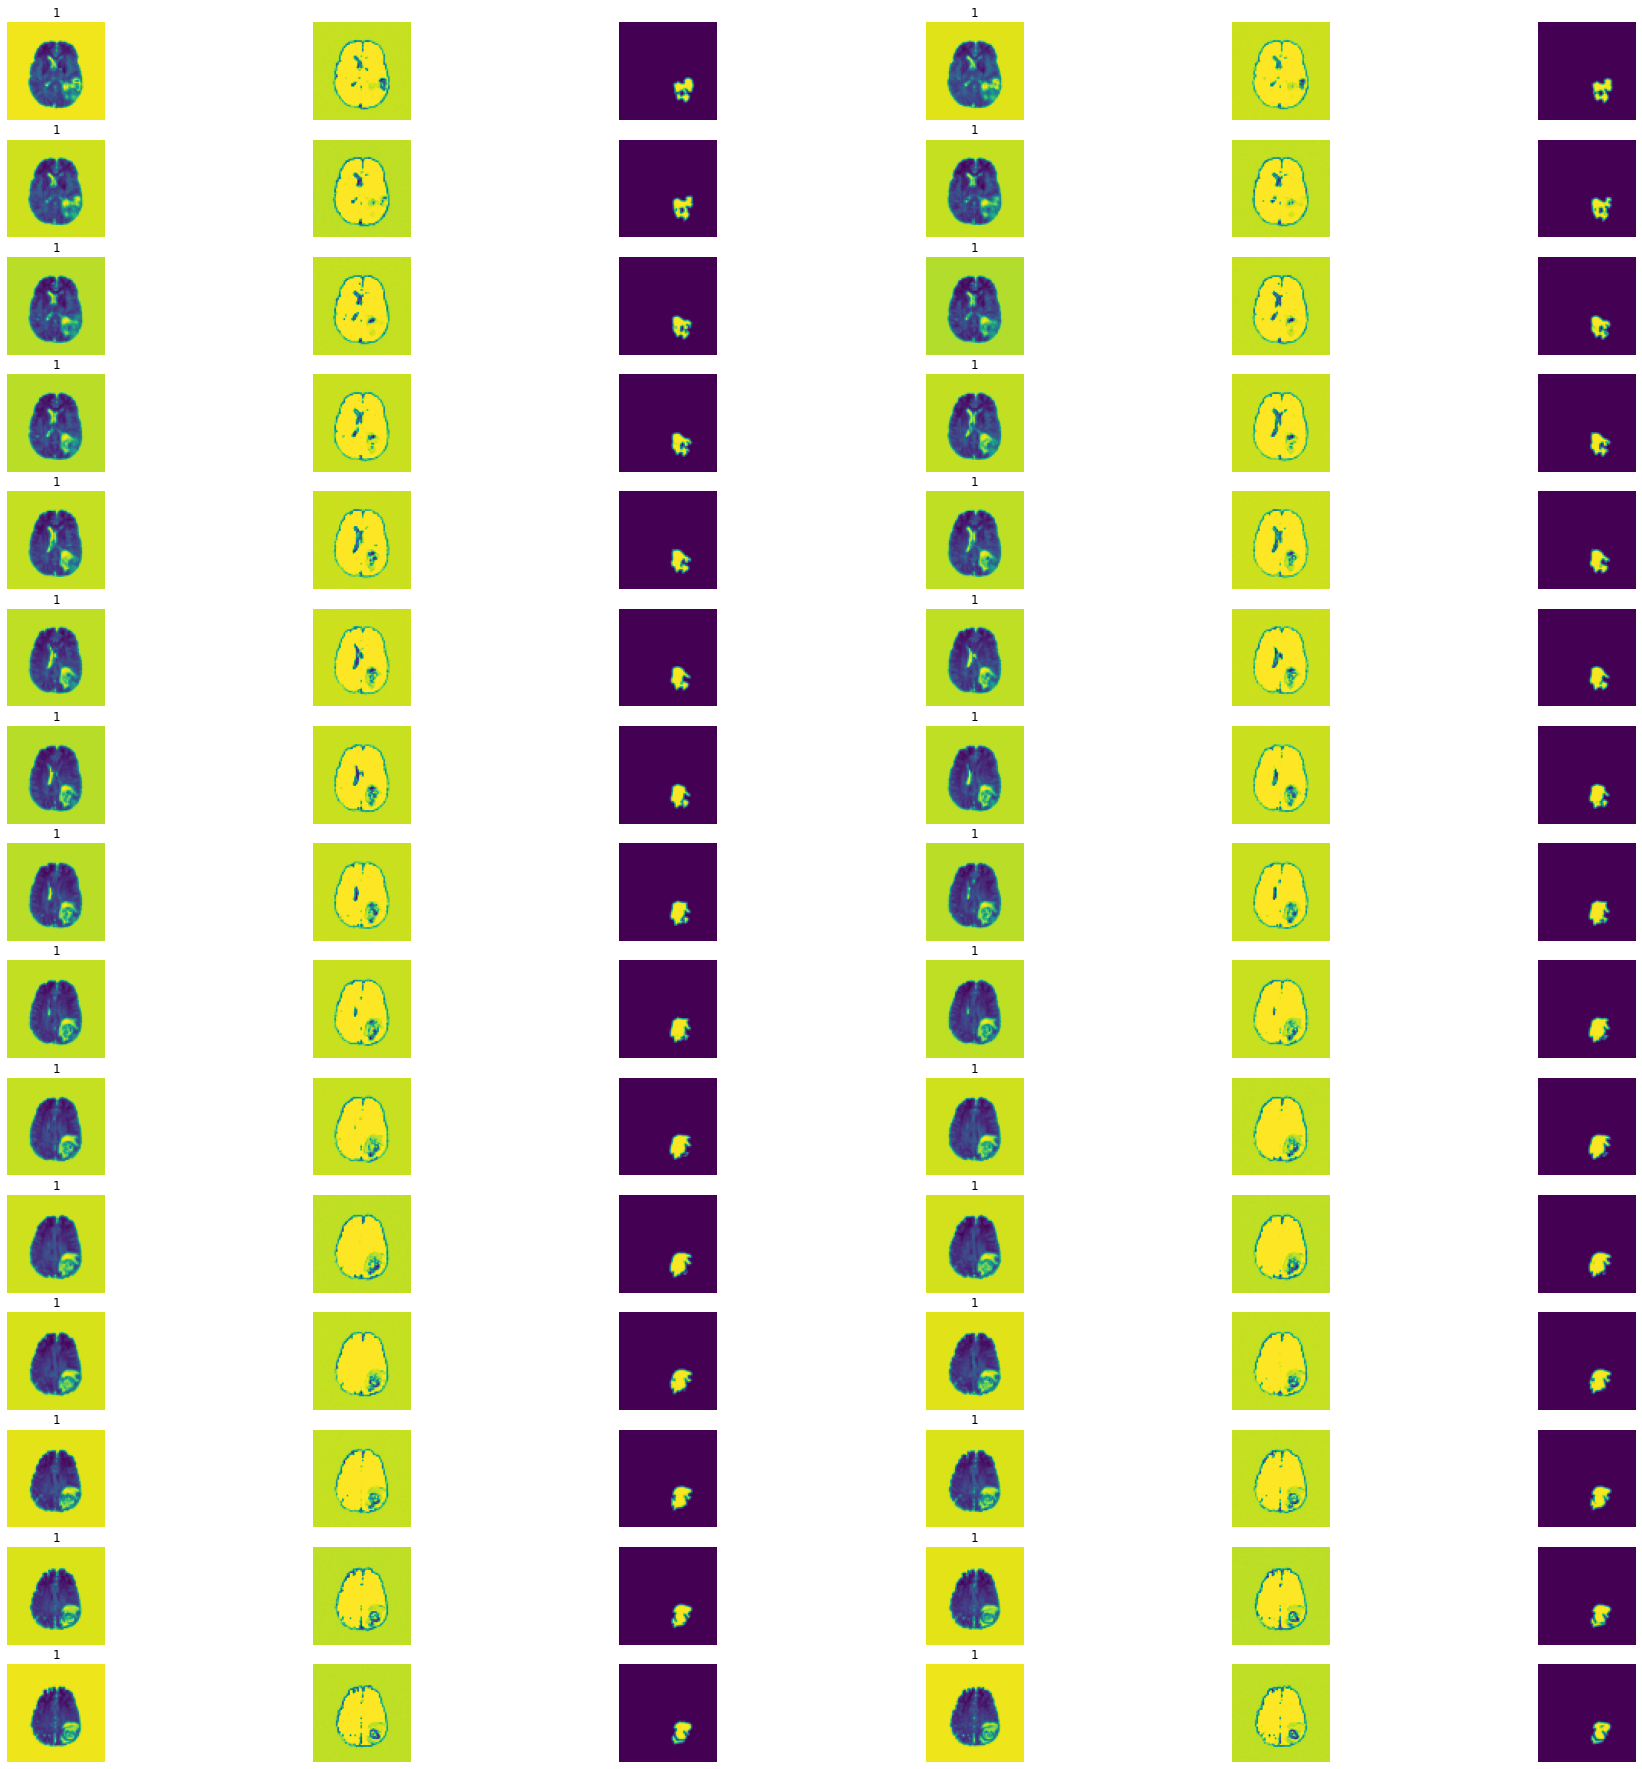

In [12]:
# 40 samples, one row 4 pictures, 10 rows
f, axarr = plt.subplots(15, 6)
f.set_figheight(32)
f.set_figwidth(32)

for i in tqdm_notebook(range(30)):
    i_ = i
    start_idx = i_ * 3
    idx_row = i_ // 2
    idx_col = start_idx % 6
    
    axarr[idx_row, idx_col].set_title(label_1[i].item())
    axarr[idx_row, idx_col].axis('off')
    axarr[idx_row, idx_col].imshow(data_1[i].squeeze_(0).permute(1, 2, 0)[:,:,0])
    axarr[idx_row, idx_col+1].axis('off')
    axarr[idx_row, idx_col+1].imshow(attn_1[i].permute(1, 2, 0)[:,:,0])
    axarr[idx_row, idx_col+2].axis('off')
    axarr[idx_row, idx_col+2].imshow(seg_1[i].permute(1, 2, 0))

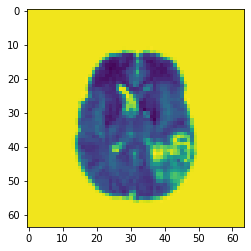

In [14]:
plt.imshow(data_1[0, 0, :, :])

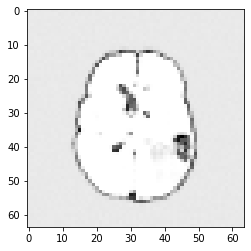

In [17]:
plt.imshow(attn_1[0, 0, :, :], cmap='gray')

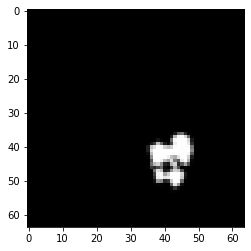

In [18]:
plt.imshow(seg_1[0, 0, :, :], cmap='gray')

In [19]:
label_1[0]

tensor(1)